In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import settings

In [2]:
development_data_path = f'{settings.raw_data_folder}control/country_development_data.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'
features_path = f'{settings.features_folder}selected_features_rfe_shap_development.csv'

In [3]:
development_data = pd.read_csv(development_data_path)
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,...,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,...,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,...,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,...,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,...,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,...,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [4]:
targets = pd.read_csv(targets_path)
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Deaths       0
Confirmed    0
Recovered    0
Country      0
dtype: int64


,Deaths,Confirmed,Recovered,Country
0,0.006186,0.142134,0.123374,Afghanistan
1,0.050951,2.967301,1.792636,Albania
2,0.006558,0.244897,0.167572,Algeria
3,0.001461,0.061687,0.056808,Angola
4,0.108227,4.356147,3.905192,Argentina


In [5]:
development_data = development_data.merge(targets, on='Country', how='inner')

In [6]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_development = development_data.columns.drop(label_values)
features_development = features_development.drop(['Country', 'WHO code', 'FAO code'])

In [7]:
X_development = development_data[features_development]
Y_development = development_data[label_values]

In [8]:
selected_features_development = pd.read_csv(features_path)
selected_features_development = selected_features_development['selected_features']

In [9]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [10]:
def cross_validation_predictions(regressor, data, target, folds=5):
  scores = {}
  n_folds = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=0)
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_median_absolute_error', n_jobs=-1).mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_squared_error', n_jobs=-1).mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut(), n_jobs=-1)
  return scores, predictions

In [11]:
PARAMS = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 75, 100, 150, 200, 250, 300, 350]
}

In [12]:
development_params, development_score = hyper_parameter_search(X_development[selected_features_development], Y_development['Deaths'], PARAMS)

In [13]:
print(f'best parameters: {development_params}')
print(f'score: {development_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200}
score: -0.02133306253939136


In [14]:
xgb_development = XGBRegressor(gamma = development_params['gamma'],
                               learning_rate = development_params['learning_rate'], 
                               max_depth = development_params['max_depth'],
                               min_child_weight = development_params['min_child_weight'],
                               n_estimators = development_params['n_estimators'])

In [15]:
scores_development, predictions_development = cross_validation_predictions(xgb_development, X_development[selected_features_development],
                                                             Y_development['Deaths'])

In [16]:
scores_development

{'neg_mean_absolute_error': -0.022201637913716103,
 'neg_median_absolute_error': -0.022201637913716103,
 'neg_mean_squared_error': -0.0010454365126842185}

In [17]:
print(f'r2_score = {r2_score(Y_development["Deaths"], predictions_development)}')
print(f'mse = {mean_squared_error(Y_development["Deaths"], predictions_development)}')
print(f'mae = {mean_absolute_error(Y_development["Deaths"], predictions_development)}')

r2_score = 0.5630199881742896
mse = 0.0010454365126842185
mae = 0.022201637913716103


In [18]:
abs_difs_development = np.abs(predictions_development - Y_development['Deaths'].values)

In [19]:
ordered_values = []
for i in range(len(abs_difs_development)):
  node = {}
  node['predicted'] = predictions_development[i]
  node['actual'] = Y_development['Deaths'].values[i]
  node['error'] = abs_difs_development[i]
  node['country'] = development_data.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

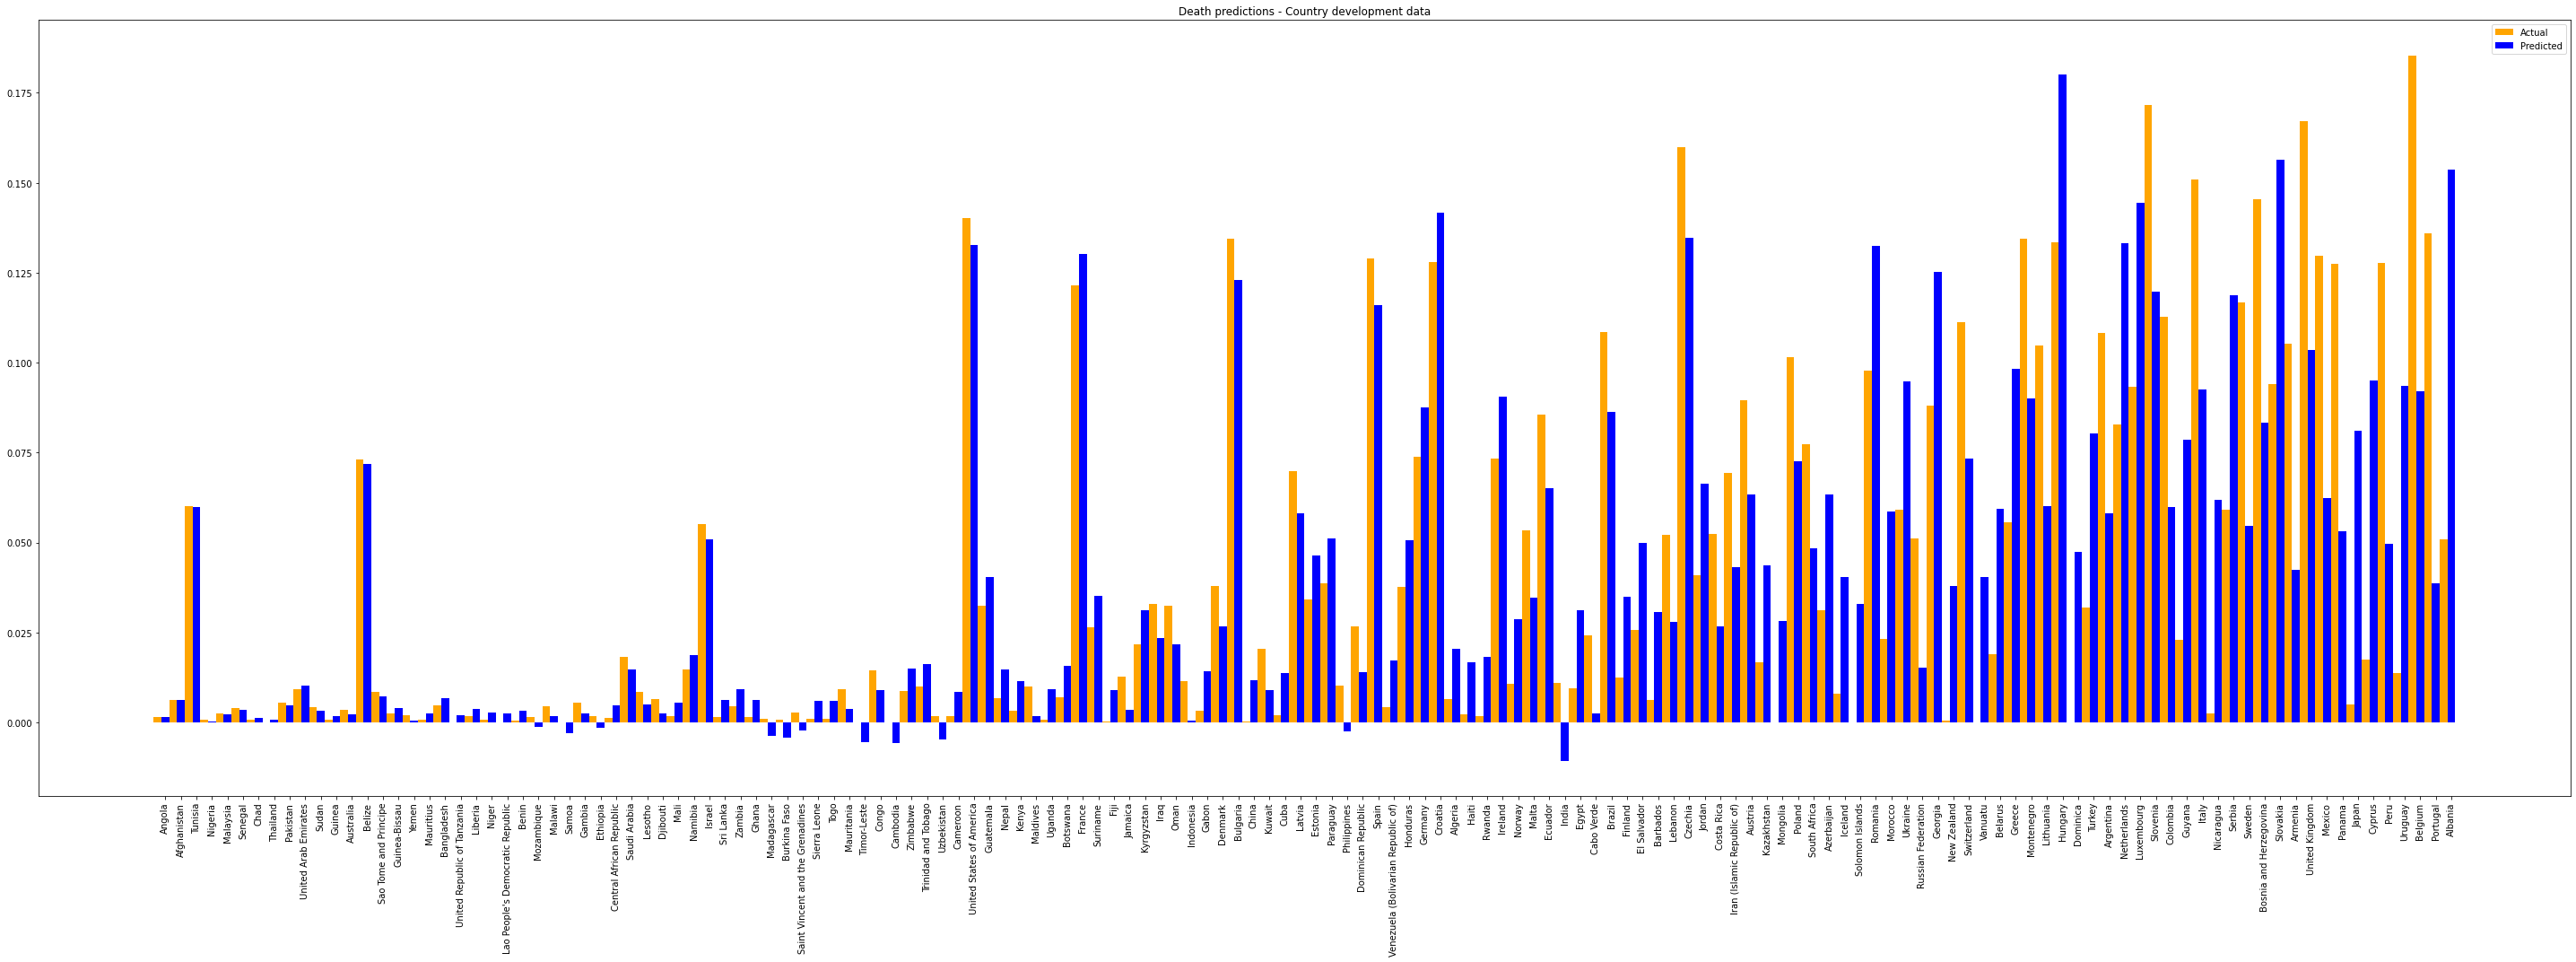

In [20]:
x = np.arange(1, len(X_development) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Country development data')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.savefig("Deaths prediction distribution using development data.png")

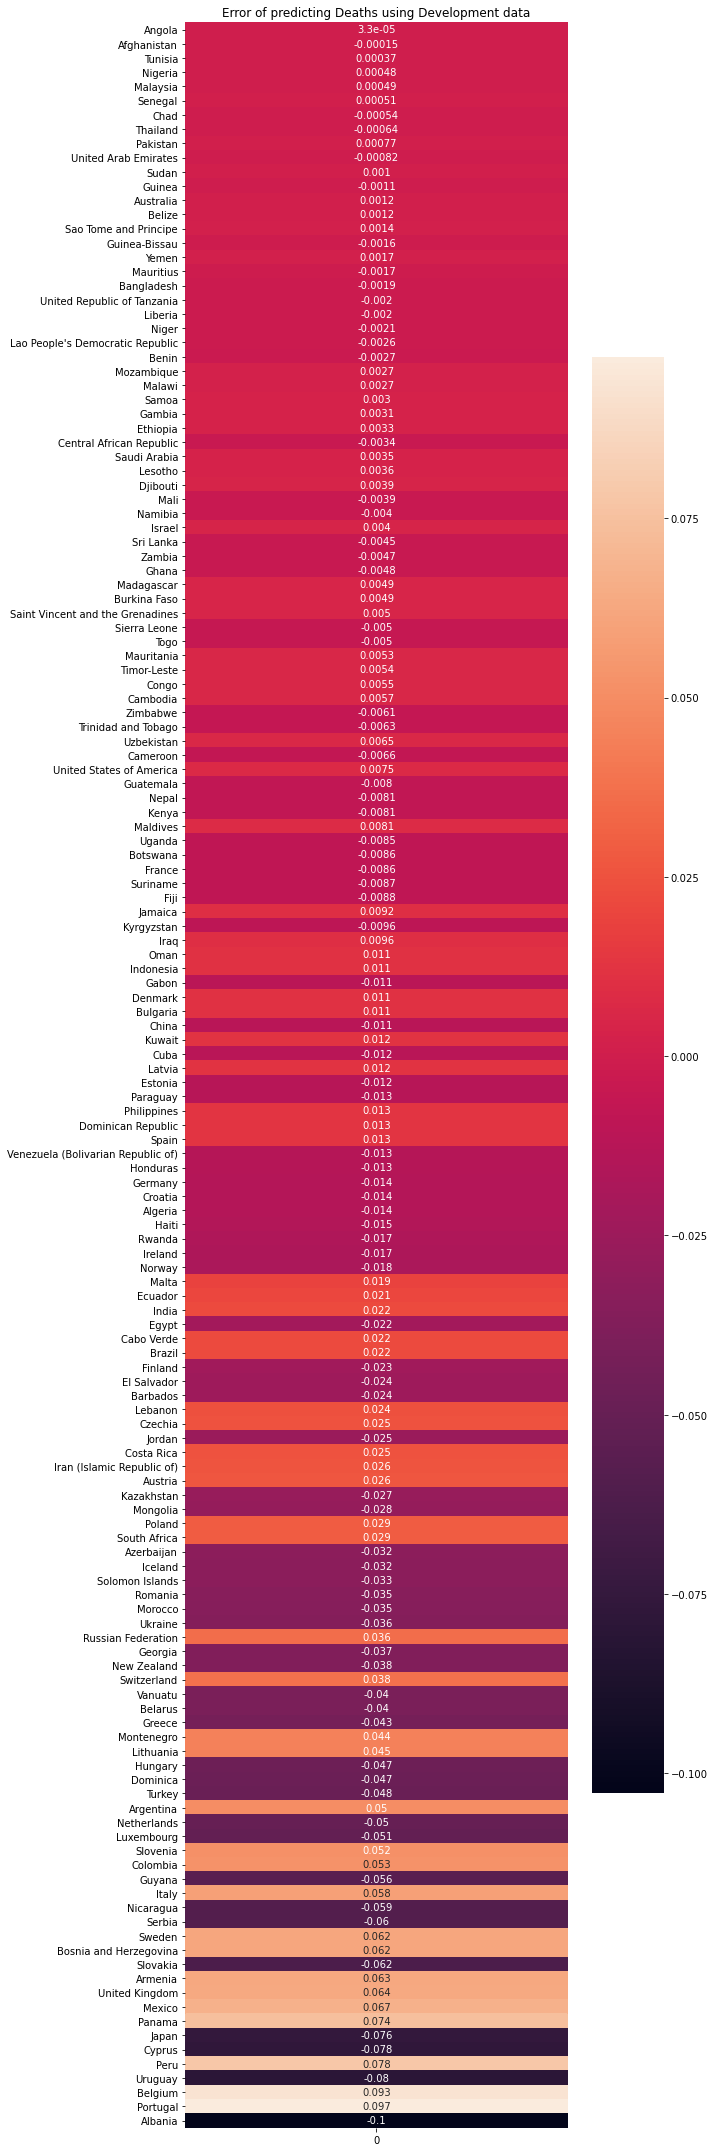

In [21]:
errors_development = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_development = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_development, annot=True, yticklabels=countries_development)
plt.title("Error of predicting Deaths using Development data")
plt.tight_layout()
plt.savefig("Error of predicting Deaths using development data.png")